# Carregamento de Dados

Objetivos dessa aula:
* Carregar dados reais do Pytorch
* Implementar o fluxo de treinamento completo de uma rede

Mas calma que essa ainda não é a linha de chegada. Ainda precisaremos falar do fluxo de validação.

## Hiperparâmetros

Agora que a brincadeira está ficando séria, que tal uma sugestão de como organizar o seu código? Para facilitar o entendimento e manutenção do código, mantenha sempre no início os seguintes elementos:
* imports de pacotes
* configuração de hiperparâmetros
* definição do hardware padrão utilizado

Nessa aula vamos trabalhar com dados reais, então **vamos precisar de GPU!** Então não se esqueça de mudar as configurações desse ambiente do colab. <br>
Sugiro rodar esse mesmo código sem GPU em outro momento, só pra sentir o gostinho de como a GPU facilitou o uso de redes neurais.

In [1]:
import torch
from torch import nn, optim

from torchvision import datasets
from torchvision import transforms 

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time

args = {
    'batch_size': 5,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

cuda


## Datasets

O PyTorch possui dois pacotes que trazem datasets prontos para uso.

* Torchtext: https://torchtext.readthedocs.io/en/latest/datasets.html
* Torchvision: https://pytorch.org/docs/stable/torchvision/datasets.html

Como os nomes indicam, são datasets de textos (text) e imagens (vision), duas aplicações onde redes neurais são muito bem sucedidas.

Para aplicações com textos e outros tipos de séries temporais, o carregamento de dados possui nuances que dificultam o entendimento, portanto vamos concentrar no carregamento de imagens.

### Torchvision datasets

Para trabalhar com datasets do pacote torchvision, basta
* Importar o pacote
``` python 
from torchvision import datasets 
```
* Carregar o dataset do seu interesse (ex: MNIST)
``` python 
data = datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
```

Documentação: https://pytorch.org/docs/stable/torchvision/datasets.html

### Torchvision transforms

Não vamos entrar em detalhes sobre transformações de imagens, mas para qualquer dataset é necessário transformá-lo em tensor para que possamos alimentar uma rede em pytorch. Isso pode ser feito no carregamento dos dados, basta:

* Importar o pacote transforms
``` python 
from torchvision import transforms 
```
* preencher o parâmetro ```tranform``` do dataset com a função que converte para tensor.
``` python 
transforms.ToTensor() 
```

Pronto! Quando seu dado for carregado, ele passará pela transformação indicada no parâmetro ```tranform```, nesse caso, convertendo o dado para um tensor.

Documentação: https://pytorch.org/docs/stable/torchvision/transforms.html


In [2]:
train_set = datasets.MNIST('./', 
                           train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

test_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(train_set)) + '\nAmostras de Teste:' + str(len(test_set)))

100%|██████████| 9912422/9912422 [00:00<00:00, 397473338.86it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111031800.02it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 150870231.17it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5646274.09it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Amostras de treino: 60000
Amostras de Teste:10000


Cada dataset possui uma implementação específica internamente no pytorch. Verifique o ```type``` da variável que recebeu os dados e veja que se refere a uma classe específica do dataset.

No entanto, o item de qualquer dataset **sempre será uma tupla ```(dado, rótulo)```**. 

In [3]:
print(type(train_set))
print(type(train_set[0]))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>


Podemos então iterar no dataset para observar algumas amostras e seus rótulos.

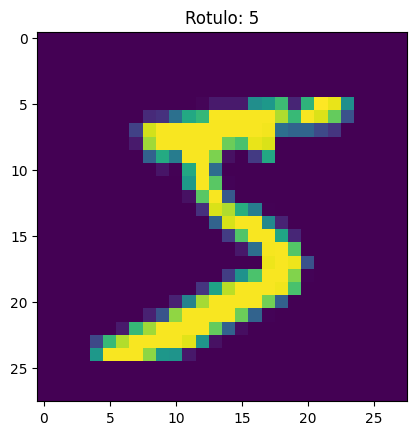

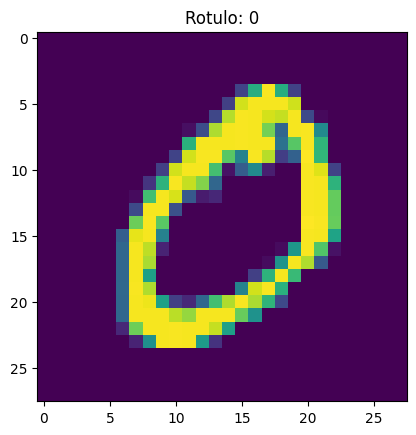

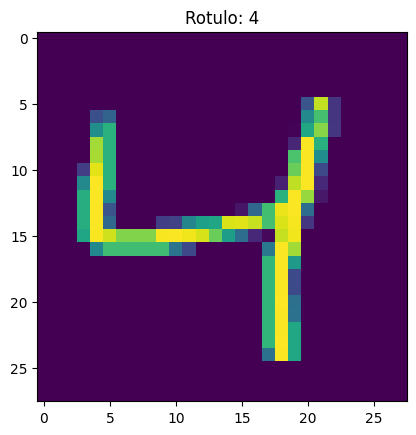

In [4]:
for i in range(3):
  dado, rotulo = train_set[i]

  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

Temos um total de 70 mil amostras, mas elas **ainda não estão carregadas na memória** (isso seria bastante custoso). A vantagem da classe ```Dataset``` do Pytorch é que as amostras só são carregadas quando necessário.

Sugestão: experimente trocar a transformação do Dataset para
```python
transforms.RandomCrop(12)
```
Essa função realiza um recorte aleatório de ```12 x 12``` (pixels) na imagem. Ao carregar a mesma amostra múltiplas vezes, um novo recorte será feito. 

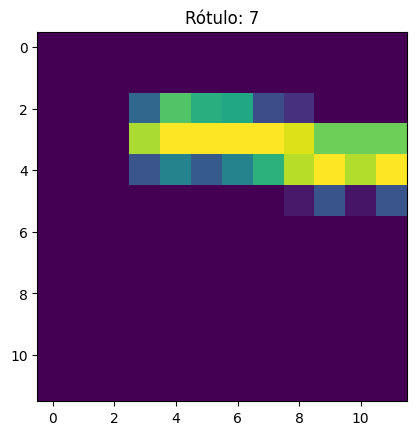

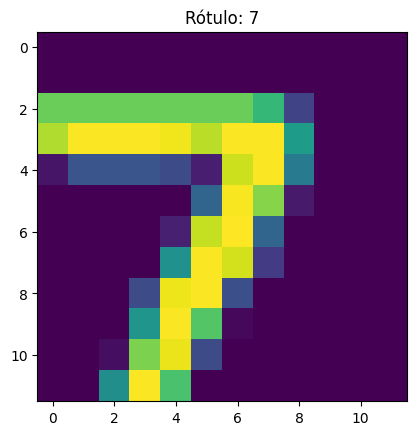

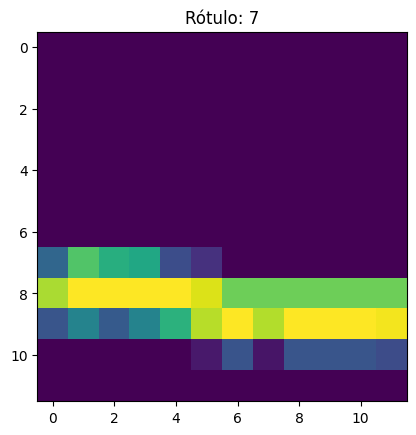

In [5]:
crop_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.RandomCrop(12),
                           download=False)

# Tuple (dado, rótulo)
for i in range(3):
  dado, rotulo = crop_set[0]
  
  plt.figure()
  plt.imshow(dado)
  plt.title('Rótulo: '+ str(rotulo))

Em resumo, cada vez que indexamos um item do dataset, as seguintes operações são realizadas:
* Amostra lida do arquivo e carregada como uma tupla ```(dado, rótulo)```
* As transformações são aplicadas 

## Dataloader

Essa aqui é uma das principais razões do Pytorch ser o pacote preferido de muitos profissionais. O Dataloader gerencia muito bem o carregamento de dados para o treinamento de redes neurais, trazendo as funções: 

* Separação dos dados em batches
* Embaralhando os dados
* Carregando batches em paralelo utilizando threads

O uso de threads no carregamento minimiza períodos ociosos de processamento, visto que a leitura de dados em arquivo é um grande gargalo de tempo.

As três funcionalidades que acabamos de conhecer são controladas pelos parâmetros da chamada do DataLoader.
```python
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
```


In [6]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


O objeto retornado é um **iterador**, podendo ser utilizado para iterar em loops mas não suportando indexação.

torch.Size([5, 1, 28, 28]) torch.Size([5])


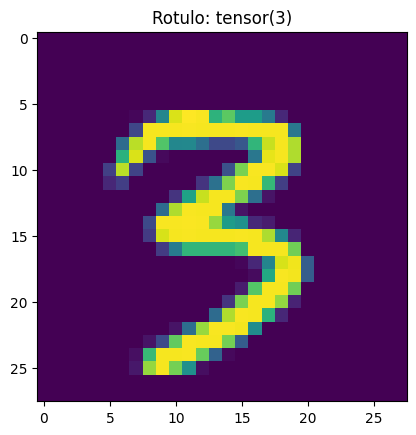

In [7]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0])
  plt.title('Rotulo: '+ str(rotulo[0]) )
  break

## Implementando o MLP


**Lembrete**: Multi-Layer Perceptrons trabalham somente com dados unidimensionais (vetores). Sendo a imagem com dimensionalidade ```(1, 28, 28)```, precisamos linearizá-la antes de alimentar a rede. Isso implica que o a entrada da rede terá ```input_size = 28 x 28 x 1 = 784```

In [8]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()

  def forward(self, X):
    
    X = X.view(X.size(0), -1)

    feature = self.features(X)
    output  = self.softmax(self.out(feature))

    return output

input_size  = 28 * 28
hidden_size = 128
out_size    = 10 #classes

torch.manual_seed(42)
net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU 

## Definindo loss e otimizador

In [9]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Fluxo de Treinamento

Agora vamos aplicar o conhecimento que acabamos de aprender!

Relembrando o passo a passo do fluxo de treinamento:
* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Cálculo do gradiente e atualização dos pesos

Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir a média e o desvio padrão das perdas de cada iteração.

In [10]:
for epoch in range(args['num_epochs']):
  start = time.time()

  epoch_loss = []
  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward 
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  end = time.time()

  print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start) )


<ipython-input-8-3d244f14b03b>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output  = self.softmax(self.out(feature))


Epoca 0, Loss: 1.8398 +\- 0.2292, Tempo: 46.66
Epoca 1, Loss: 1.9688 +\- 0.2239, Tempo: 43.19
Epoca 2, Loss: 2.1020 +\- 0.2239, Tempo: 43.89
Epoca 3, Loss: 2.1935 +\- 0.1982, Tempo: 42.71
Epoca 4, Loss: 2.3086 +\- 0.1638, Tempo: 44.30
Epoca 5, Loss: 2.3567 +\- 0.1374, Tempo: 43.20
Epoca 6, Loss: 2.3590 +\- 0.1342, Tempo: 43.78
Epoca 7, Loss: 2.3590 +\- 0.1357, Tempo: 43.97
Epoca 8, Loss: 2.3590 +\- 0.1350, Tempo: 44.25
Epoca 9, Loss: 2.3590 +\- 0.1338, Tempo: 43.92
Epoca 10, Loss: 2.3590 +\- 0.1357, Tempo: 43.95
Epoca 11, Loss: 2.3590 +\- 0.1347, Tempo: 43.28
Epoca 12, Loss: 2.3590 +\- 0.1351, Tempo: 43.98
Epoca 13, Loss: 2.3590 +\- 0.1349, Tempo: 43.47
Epoca 14, Loss: 2.3590 +\- 0.1358, Tempo: 45.11
Epoca 15, Loss: 2.3590 +\- 0.1351, Tempo: 43.43
Epoca 16, Loss: 2.3590 +\- 0.1362, Tempo: 44.17
Epoca 17, Loss: 2.3590 +\- 0.1351, Tempo: 42.94
Epoca 18, Loss: 2.3590 +\- 0.1357, Tempo: 44.55
Epoca 19, Loss: 2.3590 +\- 0.1347, Tempo: 43.74
Epoca 20, Loss: 2.3590 +\- 0.1357, Tempo: 44.01
Ep

### Interpretando a qualidade do modelo

Apesar da loss ser o critério utilizado na otimização do modelo, seu valor é pouco interpretável por seres humanos.

* *A loss está melhorando, mas como saber se meu modelo está bom mesmo?*

Podemos calcular uma métrica mais interpretável. No caso da classificação, temos a acurácia como métrica mais simples de avaliação. Esse valor será usado exclusivamente para visualizar a qualidade do modelo, não interferindo no treinamento da rede. 

Na célula anterior utilizaremos a biblioteca Scikit-Learn para calcular a acurácia, para isso basta
* Armazenar os rótulos de cada iteração
* Calcular a predição a partir da saída da rede
* Utilizar a função do sklearn para cálculo da acurácia
```python
metrics.accuracy_score(rotulos, ypreds)
```

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html